**Installing all dependencies**

In [ ]:
! pip install gensim
! pip install nltk
! pip install sklearn
! pip install jsonlines
! pip install matplotlib
! pip install pandas
! pip install seaborn
! pip install networkx


In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os, shutil

sys.path.append('/usr/local/lib/python3.7/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ["CONDA_PREFIX"] = "/usr/local"
for so in ['cudf', 'rmm', 'nccl', 'cuml', 'cugraph', 'xgboost', 'cuspatial']:
  fn = 'lib'+so+'.so'
  source_fn = '/usr/local/lib/'+fn
  dest_fn = '/usr/lib/'+fn
  if os.path.exists(source_fn):
    print(f'Copying {source_fn} to {dest_fn}')
    shutil.copyfile(source_fn, dest_fn)
# fix for BlazingSQL import issue
# ImportError: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /usr/local/lib/python3.7/site-packages/../../libblazingsql-engine.so)
if not os.path.exists('/usr/lib64'):
    os.makedirs('/usr/lib64')
for so_file in os.listdir('/usr/local/lib'):
  if 'libstdc' in so_file:
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib64/'+so_file)
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib/x86_64-linux-gnu/'+so_file)

In [ ]:
! nvcc --version

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


**Embedding**

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
# Uncomment to install dependencies
# import nltk
# nltk.download('punkt')

import json
import jsonlines
import os
import numpy as np

# Change the paths to suit your environment
raw_data_path = "/content/drive/MyDrive/cs453_codes/data_all.jsonl"
target_data_path = "/content/drive/MyDrive/cs453_codes/embedded_all.npy"
code_model_path = "/content/drive/MyDrive/cs453_codes/code.model"
edit_model_path = "/content/drive/MyDrive/cs453_codes/edit.model"

exists = os.path.exists(edit_model_path)

with jsonlines.open(raw_data_path) as reader:
        data = [line for line in reader]

if(not exists):

    edit_actions = []

    for i, d in enumerate(data):
        A = TaggedDocument(words = d['edit_actions'], tags=[str(i)])
        
        edit_actions.append(A)


    edit_data = edit_actions

    seed = 96
    
    edit_config = {
        "epochs": 20,
        "vec_size": 50,
        "alpha": 0.025
    }


    edit_model = Doc2Vec(vector_size=edit_config['vec_size'],
                    alpha=edit_config['alpha'], 
                    min_alpha=0.00025,
                    min_count=1,
                    dm = 1,
                    seed = seed)
    
    edit_model.build_vocab(edit_data)

    # edit actions
    for epoch in range(edit_config['epochs']):
        print('model 1 iteration {0}'.format(epoch))
        edit_model.train(edit_data,
                    total_examples=edit_model.corpus_count,
                    epochs=edit_model.epochs)
        
        edit_model.alpha -= 0.0002
        edit_model.min_alpha = edit_model.alpha


    edit_model.save(edit_model_path)

else:
    edit_model = Doc2Vec.load(edit_model_path)


embedded = np.empty((len(data), int(edit_model.vector_size)))

for i in range(len(data)):

    A_vector = edit_model[str(i)]

    embedded[i] = A_vector

np.save(target_data_path, embedded)

**Clustering**

In [ ]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from cuml.manifold import TSNE
# from cuml.decomposition import PCA

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
# from cuml import KMeans
from sklearn.mixture import GaussianMixture
import jsonlines

# HYPER-PARAMETERS
seed = 96
n_clusters = 5
THRESHOLD = 0.4 # of max distance within cluster

def most_neighbours(cluster, indices, key, metric = "cosine"):
  
  G = nx.Graph()
  
  for i in range(len(cluster)):
     G.add_node(i)

  for i in range(len(cluster)):
    if(i == len(cluster) - 1):
      break
    for j in range(i + 1, len(cluster)):
      v1 = cluster[i].reshape(1, -1)
      v2 = cluster[j].reshape(1, -1)
      dist = cosine_distances(v1, v2)
      if(dist > THRESHOLD):
        G.add_edge(i, j)  

  i = nx.pagerank(G)
  i = max(i, key=i.get)

  return indices[key][i]


def get_K_embeds(embeds, labels, K):

  indices = {}
  for i in range(K):
    indices[i] = []

  for i in range(len(labels)):
    indices[labels[i]].append(i)

  K_embeds = {}
  for i in range(K):
    cluster = [embeds[ind] for ind, cl in enumerate(labels) if cl == i]
    K_embeds[i] = most_neighbours(cluster, indices, i)

  return K_embeds

raw_data_path = "/content/drive/MyDrive/cs453_codes/data_all.jsonl"

embs_path = '/content/drive/MyDrive/cs453_codes/embedded_all.npy'

In [ ]:
print('Loading embeddings...')
embs = np.load(embs_path)

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=seed)
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=seed)

# print('Clustering...')
# gmm_labels = gmm.fit_predict(embs)
# kmeans_labels = kmeans.fit_predict(embs)

print('Finished!')
gmm_labels = np.load('/content/drive/MyDrive/cs453_codes/gmm' + str(n_clusters) + '.npy')
kmeans_labels = np.load('/content/drive/MyDrive/cs453_codes/kmeans' + str(n_clusters) + '.npy')


# np.save('/content/drive/MyDrive/cs453_codes/gmm' + str(n_clusters) + '.npy', gmm_labels)
# np.save('/content/drive/MyDrive/cs453_codes/kmeans' + str(n_clusters) + '.npy', kmeans_labels)

Loading embeddings...
Finished!


**Visualization**

In [ ]:
pca = PCA(random_state=seed)
pca_data = pca.fit_transform(embs)
# proj_embs = pca_data

tsne = TSNE(n_components=2, random_state=seed, perplexity=50.0)
proj_embs = tsne.fit_transform(pca_data)

[W] [01:57:50.312469] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defauts to using min(n_samples, n_features) rather than 1
[W] [01:57:51.196143] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


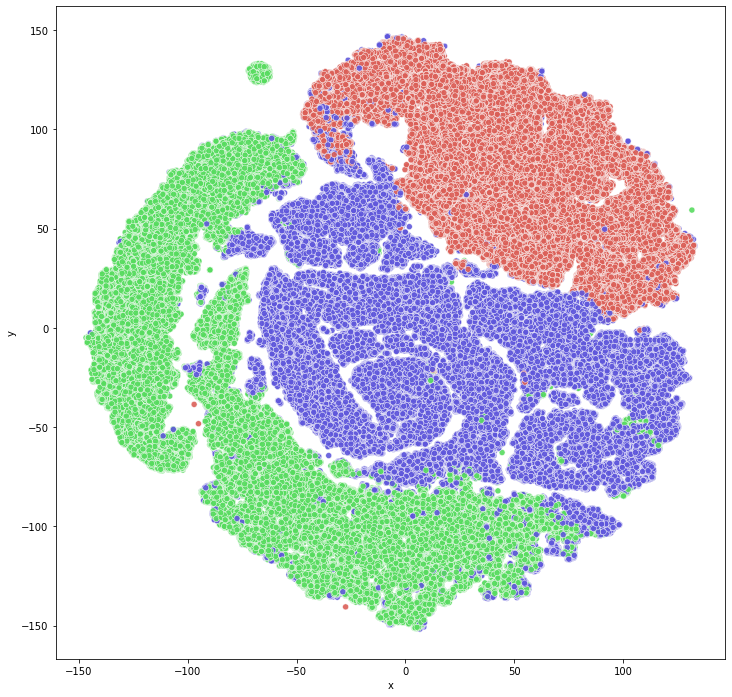

In [ ]:
data = pd.DataFrame()
data["x"] = proj_embs[:,0]
data["y"] = proj_embs[:,1]

# data["cluster"] = kmeans_labels
# model_name = "kmeans"
model_name = "gmm"
data["cluster"] = gmm_labels

plt.figure(figsize=(12, 12))
sns_plot = sns.scatterplot(
    x="x", y="y",
    hue="cluster",
    palette=sns.color_palette("hls", n_clusters),
    data=data,
    legend=None,
    alpha=0.9
)
sns_plot.get_figure().savefig("/content/drive/MyDrive/cs453_codes/" + model_name + "_" + str(n_clusters) + "_pca+tsne.jpeg")

**Sampling**

In [ ]:
model_name = "kmeans"
samples_path = '/content/drive/MyDrive/cs453_codes/samples_' + model_name + "_" + str(n_clusters) + '.jsonl'

# Sampling
# K_examples = get_K_embeds(embs, gmm_labels, n_clusters)
K_examples = get_K_embeds(embs, kmeans_labels, n_clusters)

with jsonlines.open(raw_data_path) as reader:
  data = [line for line in reader]

representative = []
for i in K_examples.keys():
  index = K_examples[i]
  representative.append( data[index] )


with jsonlines.open(samples_path, mode='w') as writer:
  for repr in representative:
    writer.write(repr)